<a href="https://colab.research.google.com/github/chardiwall/Coding-for-beginners-and-beyond/blob/main/DPSNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Discription
**Title:** DPSNN (A Differentially Private Spiking Neural Network with Temporal Enhanced Polling).

**Objectives:** Implementation of the [paper](https://arxiv.org/pdf/2205.12718.pdf).

**Discription:** The project is set in the context of the growing field of social robotics, which involves the deployment of robots in human-centric environments. These environments can range from healthcare facilities and educational institutions to customer service and domestic settings. The unique aspect of this project lies in its focus on privacy-preserving mechanisms, an increasingly critical concern in today's data-driven world.

---

SNN framwork: [SNNTorch](https://snntorch.readthedocs.io/en/latest/)

DP framwork: [Opacus](https://github.com/pytorch/opacus)

---
Datasets
- Neuromorphic DataSets:
  - [N-MNIST](https://www.garrickorchard.com/datasets/n-mnist#h.p_ID_38)
  - [CIFAR10-DVS](https://figshare.com/articles/dataset/CIFAR10-DVS_New/4724671/2)

- Static Datasets:
  - [MNIST](https://yann.lecun.com/exdb/mnist/)
  - [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html)


# Loading Essential Libraries

In [ ]:
# !pip install -q braincog
# # additional dependencies for working with neuromorphic data.
# !pip install git+https://github.com/BrainCog-X/tonic_braincog.git

# !pip install -q opacus
!pip install -q snntorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 8.8 MB/s eta 0:00:00


In [ ]:
# Mounting Google Drive as drive
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
import os
import sys
import tqdm
import itertools
from glob import glob
from zipfile import ZipFile

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms

# imports
import snntorch as snn
from snntorch import surrogate
from snntorch import backprop
from snntorch import functional as SF
from snntorch import utils
from snntorch import spikeplot as splt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools

BATCH_SIZE = 64
DEVICE = 'cpu'

<ipython-input-2-da00e9a03b38>:22: DeprecationWarning: The module snntorch.backprop will be deprecated in  a future release. Writing out your own training loop will lead to substantially faster performance.
  from snntorch import backprop


# Unzipping and Loading Data

## Neuromorphic Data

In [ ]:
# N-MNIST

# unzipping the data
base_dir_path = '/content/drive/MyDrive/Colab Notebooks/DPSNN/N-MNIST/'
train_zip_name = 'Copy of Train'
test_zip_name = 'Copy of Test'

for zip_file in [train_zip_name, test_zip_name]:
  zip_path = os.path.join(base_dir_path, zip_file+'.zip')

  with ZipFile(zip_path, 'r') as zip_ref:
    # extraction_path = os.path.join(base_dir_path, zip_file)
    # if not (os.path.exists(extraction_path)):
    #   os.mkdir(extraction_path)
    zip_ref.extractall(base_dir_path)


In [ ]:
# N-MNIST LOADING
# class N_Mnist_Data(Dataset):
#   def __init__(self, dir, transform = None):
#     self.dir = dir
#     self.transform = transform

#   def __len__(self):
#     return len(os.listdir(self.dir))

#   def __getitem__(self, index):




In [ ]:
# CIFAR10-DVS
base_dir_path = '/content/drive/MyDrive/Colab Notebooks/DPSNN/CIFAR10-DVS'
file_name = 'CIFAR10-DVS.zip'

with ZipFile(os.path.join(base_dir_path, file_name), 'r') as zip_ref:
  zip_ref.extractall(base_dir_path)

## Static Data

In [ ]:
# Transforming Data
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,))
])

In [ ]:
# MNIST
mnist_train = datasets.MNIST(root = '.', train=True, transform=transform, download=True)
mnist_test = datasets.MNIST(root = '.', train=False, transform=transform, download=True)

train_loader = DataLoader(mnist_train, batch_size= BATCH_SIZE, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size= BATCH_SIZE, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 255941882.30it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 96753749.06it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 147485528.38it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 15955216.72it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
# CIFAR10
cifar10_train = datasets.CIFAR10('.', train = True, transform = transform, download = True)
cifar10_test = datasets.CIFAR10('.', train = False, transform = transform, download = True)

100%|██████████| 170498071/170498071 [00:03<00:00, 54271524.85it/s]


Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


# Building SNN

In [ ]:
# neuron and simulation parameters
spike_grad = surrogate.fast_sigmoid(slope=25)
beta = 0.5
num_steps = 50

In [ ]:
# dataloader arguments
batch_size = 128

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# Define Network
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Initialize layers
        self.conv1 = nn.Conv2d(1, 12, 5)
        self.lif1 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.conv2 = nn.Conv2d(12, 64, 5)
        self.lif2 = snn.Leaky(beta=beta, spike_grad=spike_grad)
        self.fc1 = nn.Linear(64*4*4, 10)
        self.lif3 = snn.Leaky(beta=beta, spike_grad=spike_grad)

    def forward(self, x):

        # Initialize hidden states and outputs at t=0
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()

        cur1 = F.max_pool2d(self.conv1(x), 2)
        spk1, mem1 = self.lif1(cur1, mem1)

        cur2 = F.max_pool2d(self.conv2(spk1), 2)
        spk2, mem2 = self.lif2(cur2, mem2)

        cur3 = self.fc1(spk2.view(batch_size, -1))
        spk3, mem3 = self.lif3(cur3, mem3)
        return spk3, mem3

In [ ]:
#  Initialize Network
net = nn.Sequential(nn.Conv2d(1, 12, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Conv2d(12, 64, 5),
                    nn.MaxPool2d(2),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True),
                    nn.Flatten(),
                    nn.Linear(64*4*4, 10),
                    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
                    ).to(device)

In [ ]:
data, targets = next(iter(train_loader))
data = data.to(device)
targets = targets.to(device)

for step in range(num_steps):
    spk_out, mem_out = net(data)

In [ ]:
def forward_pass(net, num_steps, data):
  mem_rec = []
  spk_rec = []
  utils.reset(net)  # resets hidden states for all LIF neurons in net

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)
      mem_rec.append(mem_out)

  return torch.stack(spk_rec), torch.stack(mem_rec)

In [ ]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

In [ ]:
# already imported snntorch.functional as SF
loss_fn = SF.ce_rate_loss()

loss_val = loss_fn(spk_rec, targets)

print(f"The loss from an untrained network is {loss_val.item():.3f}")

The loss from an untrained network is 2.303


In [ ]:
acc = SF.accuracy_rate(spk_rec, targets)

print(f"The accuracy of a single batch using an untrained network is {acc*100:.3f}%")

The accuracy of a single batch using an untrained network is 14.062%


In [ ]:
def batch_accuracy(train_loader, net, num_steps):
  with torch.no_grad():
    total = 0
    acc = 0
    net.eval()

    train_loader = iter(train_loader)
    for data, targets in train_loader:
      data = data.to(device)
      targets = targets.to(device)
      spk_rec, _ = forward_pass(net, num_steps, data)

      acc += SF.accuracy_rate(spk_rec, targets) * spk_rec.size(1)
      total += spk_rec.size(1)

  return acc/total

In [ ]:
test_acc = batch_accuracy(test_loader, net, num_steps)

print(f"The total accuracy on the test set is: {test_acc * 100:.2f}%")

The total accuracy on the test set is: 9.80%


In [ ]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2, betas=(0.9, 0.999))
num_epochs = 1
loss_hist = []
test_acc_hist = []
counter = 0

# Outer training loop
for epoch in range(num_epochs):

    # Training loop
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        net.train()
        spk_rec, _ = forward_pass(net, num_steps, data)

        # initialize the loss & sum over time
        loss_val = loss_fn(spk_rec, targets)

        # Gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        # Store loss history for future plotting
        loss_hist.append(loss_val.item())

        # Test set
        if counter % 50 == 0:
          with torch.no_grad():
              net.eval()

              # Test set forward pass
              test_acc = batch_accuracy(test_loader, net, num_steps)
              print(f"Iteration {counter}, Test Acc: {test_acc * 100:.2f}%\n")
              test_acc_hist.append(test_acc.item())

        counter += 1

Iteration 0, Test Acc: 9.80%

Iteration 50, Test Acc: 85.22%

Iteration 100, Test Acc: 93.76%

Iteration 150, Test Acc: 94.97%

Iteration 200, Test Acc: 95.48%

Iteration 250, Test Acc: 94.29%

Iteration 300, Test Acc: 96.86%

Iteration 350, Test Acc: 97.03%

Iteration 400, Test Acc: 96.72%

Iteration 450, Test Acc: 96.73%

Iteration 500, Test Acc: 95.92%

Iteration 550, Test Acc: 96.33%

Iteration 600, Test Acc: 97.34%

Iteration 650, Test Acc: 96.40%

Iteration 700, Test Acc: 97.19%

Iteration 750, Test Acc: 96.50%

Iteration 800, Test Acc: 97.00%

Iteration 850, Test Acc: 97.55%

Iteration 900, Test Acc: 97.11%



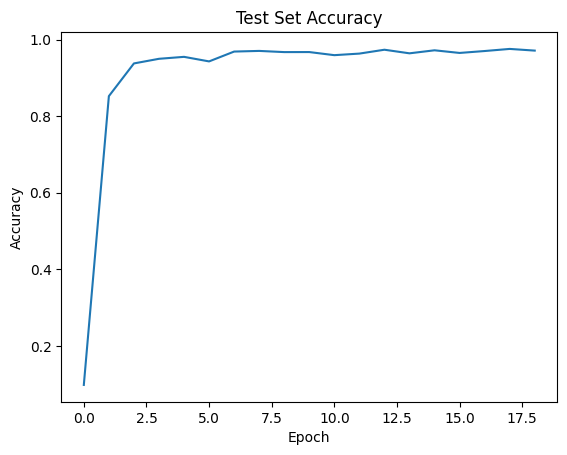

In [ ]:
# Plot Loss
fig = plt.figure(facecolor="w")
plt.plot(test_acc_hist)
plt.title("Test Set Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
spk_rec, mem_rec = forward_pass(net, num_steps, data)

The target label is: 7


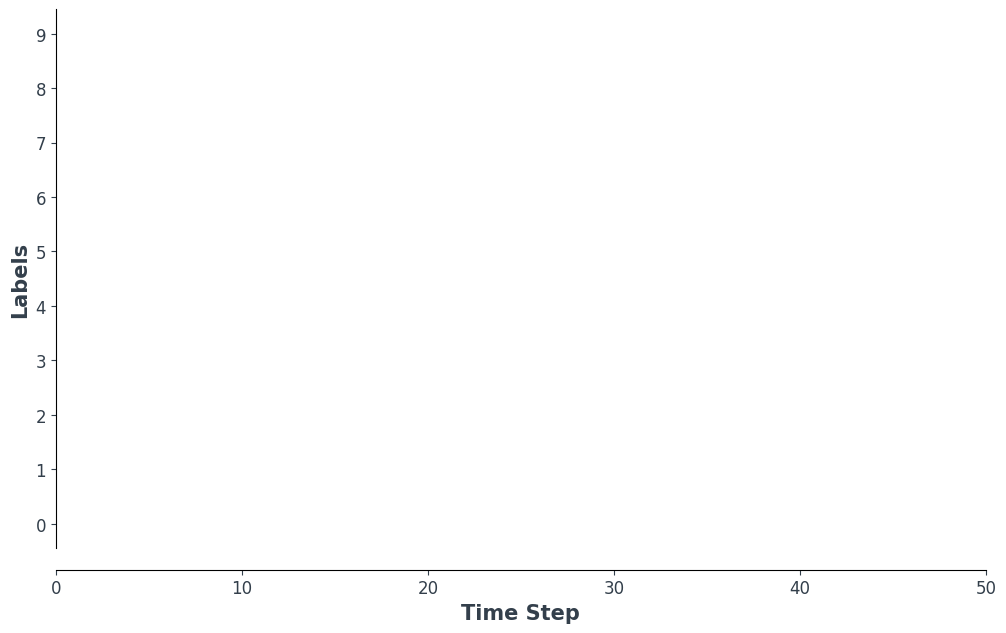

In [ ]:
from IPython.display import HTML

idx = 0

fig, ax = plt.subplots(facecolor='w', figsize=(12, 7))
labels=['0', '1', '2', '3', '4', '5', '6', '7', '8','9']
print(f"The target label is: {targets[idx]}")

# plt.rcParams['animation.ffmpeg_path'] = 'C:\\path\\to\\your\\ffmpeg.exe'

#  Plot spike count histogram
anim = splt.spike_count(spk_rec[:, idx].detach().cpu(), fig, ax, labels=labels,
                        animate=True, interpolate=4)

HTML(anim.to_html5_video())
# anim.save("spike_bar.mp4")